# **This notebook aims to apply interpretability methods for Gradient Boosting**

In [1]:
# Common imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ML imports
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OneHotEncoder
import optuna

# Interpretability ML imports
import lime
import shap

# **Data processing**

In [2]:
# Dataset Insurance

data_ins = pd.read_csv("X_train.csv")
ins_credit = pd.read_csv("y_train.csv")
ins_credit = ins_credit['evento']

data_ins.rename(columns = {'0':'age','1':'sex', '2':'smoker', '3':'pren_prod', '4':'pren_comp', '5':'point_sales', '6': 'product_type', '7': 'dist_channel', '8': 'pay_freq', '9': 'pay_method', '10':'profession'}, inplace = True)


# Categorical columns
categorial_columns = ['sex', 'smoker', 'point_sales', 'product_type', 'dist_channel', 'pay_freq', 'pay_method', 'profession']
encoder = OneHotEncoder()
encoder.fit(data_ins[categorial_columns])

ins_encoded = encoder.fit_transform(data_ins[categorial_columns]).toarray()
new_columns = encoder.get_feature_names_out(categorial_columns)
ins_encoded_df = pd.DataFrame(ins_encoded, columns=new_columns)
ins_features = data_ins.drop(columns=categorial_columns).join(ins_encoded_df)

df = pd.concat([ins_features, ins_credit], axis=1)

df.head()

,age,pren_prod,pren_comp,sex_0,sex_1,smoker_0,smoker_1,point_sales_0,point_sales_1,point_sales_2,...,pay_freq_1,pay_freq_2,pay_freq_3,pay_method_0,pay_method_1,pay_method_2,profession_0,profession_1,profession_2,evento
0,40,780.00,1.88,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,False
1,43,52.78,16.88,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,True
2,52,63.50,0.00,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,True
3,25,19.10,0.00,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,True
4,51,351.00,0.00,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,True


In [3]:
# data split 

X = df.drop(columns='evento')
y = df['evento']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# **Gradient Boosting model**

In [8]:
# fit a gb on the data
clf = GradientBoostingClassifier()
clf.fit(X_train, y_train)

# predict the test set
y_pred = clf.predict(X_test)

# compute the roc_auc 
roc_auc = roc_auc_score(y_test, y_pred)
print(f"roc_auc: {roc_auc}")

roc_auc: 0.6430888698929935


## Impact of hyperparameters


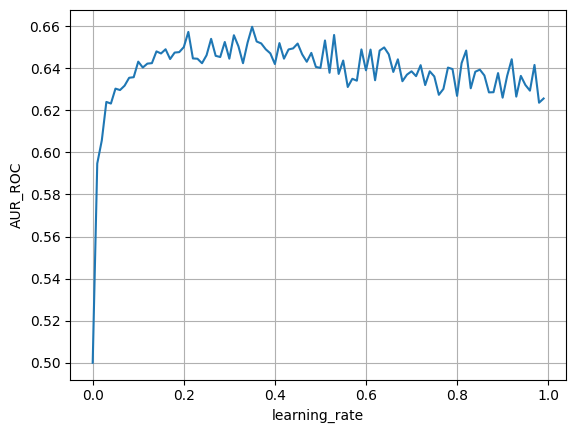

In [11]:
"""Let's study the effect of the hyperparameter learning_rate on the AUC-ROC score"""

learning_rate = [0.01*i for i in range(100)]
AUR_ROC = []

for i in learning_rate:

    # Définir le modèle SVM
    gb_model = GradientBoostingClassifier(learning_rate = i, random_state = 42)

    gb_model.fit(X_train,y_train)

    gb_death_pred = gb_model.predict(X_test)

    aur_roc = roc_auc_score(y_test,gb_death_pred)

    AUR_ROC.append(aur_roc)

plt.plot(learning_rate,AUR_ROC)
plt.ylabel('AUR_ROC')
plt.xlabel('learning_rate')
plt.grid()
plt.show()

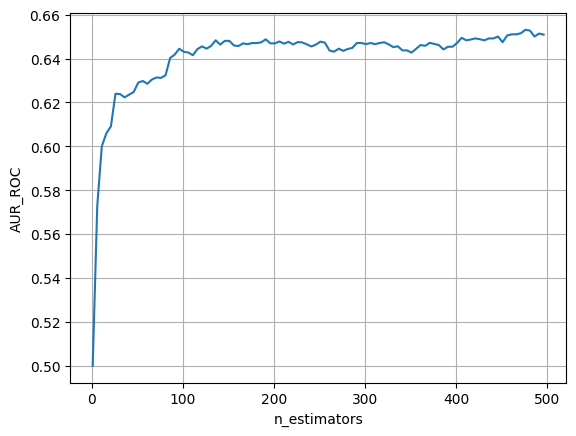

In [53]:
"""Let's study the effect of the hyperparameter n_estimators on the AUC-ROC score"""

n_estimators = [5*i + 1 for i in range(100)]
AUR_ROC = []

for i in n_estimators:

    # Définir le modèle SVM
    gb_model = GradientBoostingClassifier(n_estimators = i, random_state = 42)

    gb_model.fit(X_train,y_train)

    gb_death_pred = gb_model.predict(X_test)

    auc_roc = roc_auc_score(y_test,gb_death_pred)

    AUR_ROC.append(auc_roc)

plt.plot(n_estimators,AUR_ROC)
plt.ylabel('AUR_ROC')
plt.xlabel('n_estimators')
plt.grid()
plt.show()

## Optimization of hyperparameters


In [52]:
"""Let's use optuna first to find a relevant grid for the gridsearch"""

def objective(trial):
    # Define hyperparameters to optimize
    n_estimators = trial.suggest_int('n_estimators', 100, 500)
    max_depth = trial.suggest_int('max_depth', 3, 9)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)

    # Train GB with suggested hyperparameters using cross-validation
    clf = GradientBoostingClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        learning_rate=learning_rate,
        random_state=42
    )

    # Perform cross-validation with 5 folds
    score = cross_val_score(clf, X, y, scoring = 'roc_auc', cv=5)

    # Calculate mean accuracy
    roc_auc = score.mean()

    return roc_auc

# Create Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

# Get best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

# Train SVM with best hyperparameters on the entire dataset
best_gb = GradientBoostingClassifier(**best_params, random_state=42)
best_gb.fit(X_train, y_train)

# Predict on test set
y_pred = best_gb.predict(X_test)
roc_auc = roc_auc_score(y_test, y_pred)
print("roc_auc:", roc_auc)

[I 2024-04-16 15:22:52,252] A new study created in memory with name: no-name-4454c211-ef20-479f-818d-5c0fbc00e747
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2024-04-16 15:23:31,744] Trial 0 finished with value: 0.7060350794697865 and parameters: {'n_estimators': 452, 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 4, 'learning_rate': 0.23425631859474688}. Best is trial 0 with value: 0.7060350794697865.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
[I 2024-04-16 15:23:58,966] Trial 1 finished with value: 0.7380516123514236 and parameters: {'n_estimators': 358, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 3, 'learning_rate': 0.08030103163566679}. Best is trial 1 with value

Best Hyperparameters: {'n_estimators': 186, 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 3, 'learning_rate': 0.055616541254492446}
roc_auc: 0.6427490035737458


In [35]:
"""Let's use gridsearch to find the best hyperparameters"""

# Define the model
gb_model = GradientBoostingClassifier()

# Creation of a function allowing to create a range of values
def generate_numbers(threshold, number, num_components):
    interval = (2 * threshold * number) / (num_components - 1)
    numbers_list = []
    for i in range(num_components):
        value = (1-threshold) * number + i * interval
        if type(number) == int:
            numbers_list.append(int(value))
        else :
            numbers_list.append(value)
    return list(set(numbers_list))

# Define the grid of hyperparameters
threshold = 0.1  ## Define the range of values taken by gridsearch depending on the values obtained by optuna
num_components = 4

param_grid = {'n_estimators': generate_numbers(threshold,best_params['n_estimators'],num_components),
              'learning_rate': generate_numbers(threshold,best_params['learning_rate'],num_components),
              'max_depth': generate_numbers(threshold,best_params['max_depth'],num_components),
              'min_samples_split': generate_numbers(threshold,best_params['min_samples_split'],num_components),
              'min_samples_leaf': generate_numbers(threshold,best_params['min_samples_leaf'],num_components)}

# Create the grid search object
grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid, cv=5, scoring='roc_auc')

# Fit the model
grid_search.fit(X_train, y_train)

# Display the best hyperparameters and the best accuracy
print("Best hyperparameters :", grid_search.best_params_)
print("Best roc_auc :", grid_search.best_score_)

# Evaluate the model
best_gb_model = grid_search.best_estimator_
predictions = best_gb_model.predict(X_test)
roc_auc = roc_auc_score(y_test, predictions)
print("roc_auc :", roc_auc)


320 fits failed out of a total of 640.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
320 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\alqui\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\alqui\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "c:\Users\alqui\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\alqui\AppData\Local\Programs\Python\Python312\

Best hyperparameters : {'learning_rate': 0.04064720940291451, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 7, 'n_estimators': 244}
Best roc_auc : 0.7608624462490161
roc_auc : 0.6415105513043657


Best hyperparameters : {'learning_rate': 0.04064720940291451, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 7, 'n_estimators': 244}

Best roc_auc : 0.7608624462490161

roc_auc : 0.6415105513043657

## Learning curve


In [ ]:
# Generate the learning curve
train_sizes, train_scores, test_scores = learning_curve(
    best_gb_model, X,  y, cv=5, train_sizes=np.linspace(0.1, 1.0, 10), scoring='roc_auc')

# Calculate the mean and standard deviation of the training and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.title('GB Learning Curve')
plt.xlabel('Training dataset size')
plt.ylabel('Score')
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")

plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Validation")

plt.legend(loc="best")
plt.show()


# **Interpretability**

In this part, we will apply RVI, SHAP and LIME methods to interpret the Gradient Boosting model.

## RVI

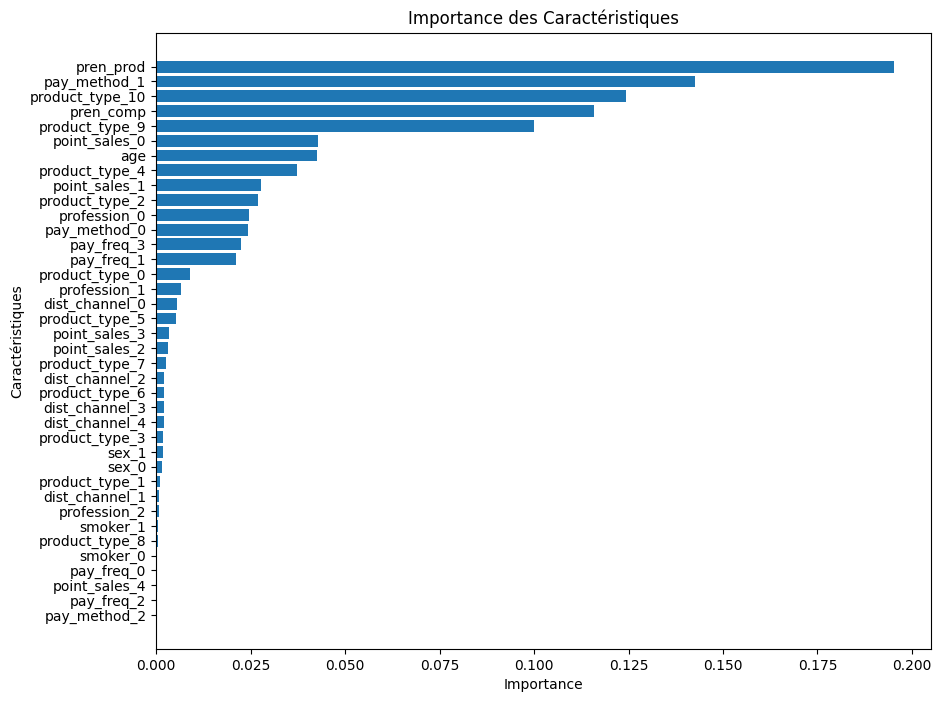

In [50]:
# Features importances for GB model
feature_importances = best_gb_model.feature_importances_

# feature names
feature_names = X_train.columns
features = np.array(X_train.columns)
sorted_idx = np.argsort(feature_importances)[::-1]

# plot
plt.figure(figsize = (10,8))
plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), features[sorted_idx])
plt.gca().invert_yaxis()  
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

## LIME

In [37]:
# Initialize LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(training_data = X_train.values, feature_names = X_train.columns, class_names=['False','True'], mode = 'classification')

# Select instance to explain
instance_idx = 0

# Explain prediction
explanation = explainer.explain_instance(X_test.iloc[instance_idx], best_gb_model.predict_proba)

# Show explanation
explanation.show_in_notebook()

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__setitem__ treating k

## SHAP

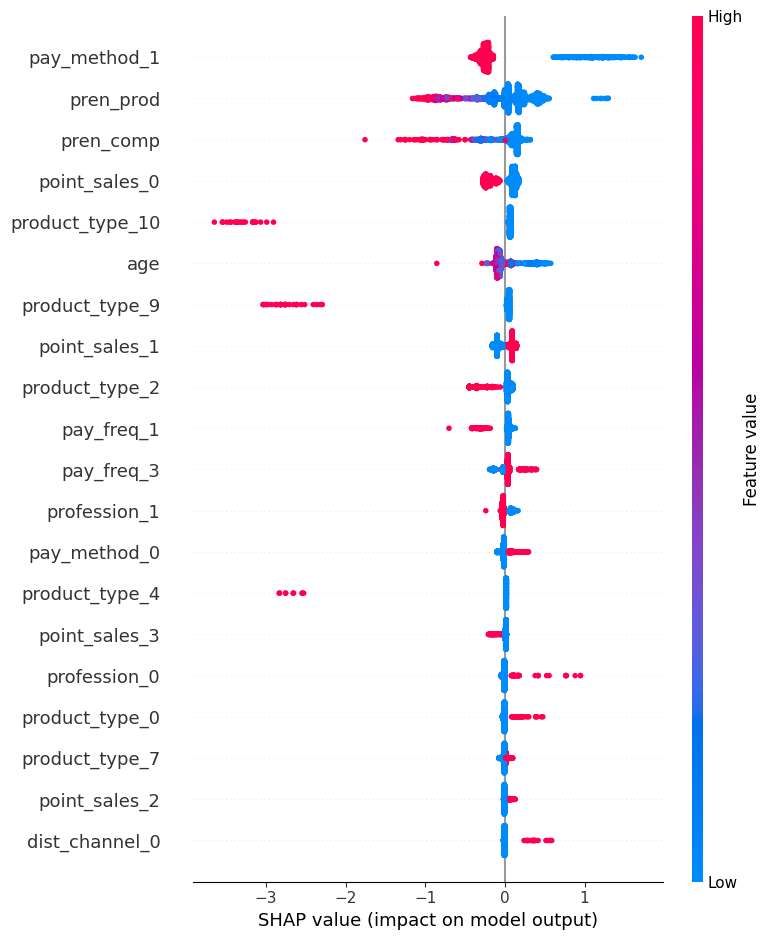

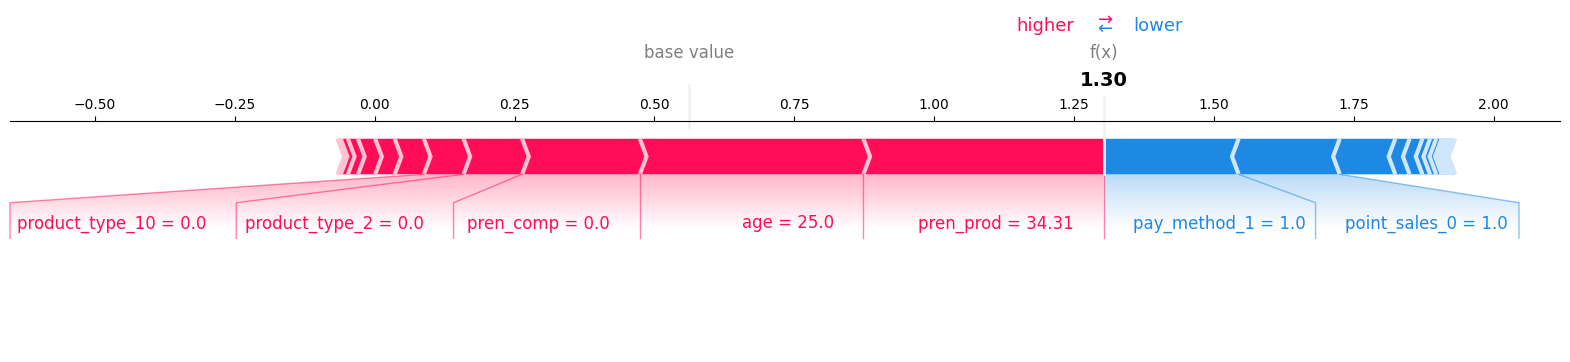

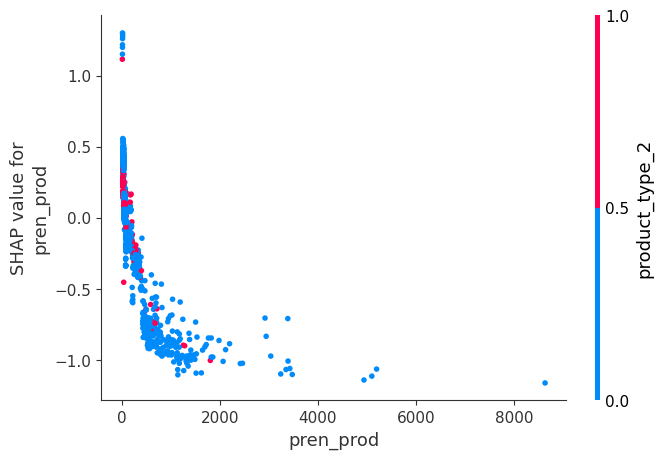

In [42]:
# Use of TreeExplainer to explain the GB model
explainer = shap.TreeExplainer(best_gb_model)
shap_values = explainer.shap_values(X_test)

# Display of interpretations
shap.summary_plot(shap_values, X_test)

# Force diagram for a specific instance
shap.initjs()
ins = 5
shap.force_plot(explainer.expected_value, shap_values[ins,:], X_test.iloc[ins,:], matplotlib = True)

# Dependency diagram for a given feature
shap.dependence_plot("pren_prod", shap_values, X_test)